In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# downloaded curl -OL https://wx.erau.edu/faculty/lehrs/ma305/sales_data.zip
# extract somewhere, mine is here...
file_name = 'c:\\temp\\ma305\\sales_data.sav'
df = pd.read_pickle(file_name)


In [26]:
corr = df.corr()
# print(corr)

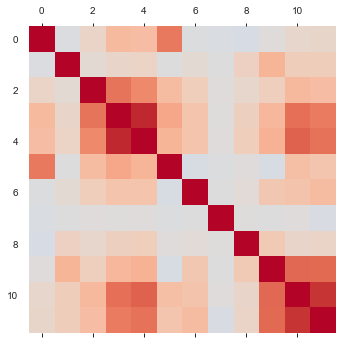

In [27]:
plt.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)


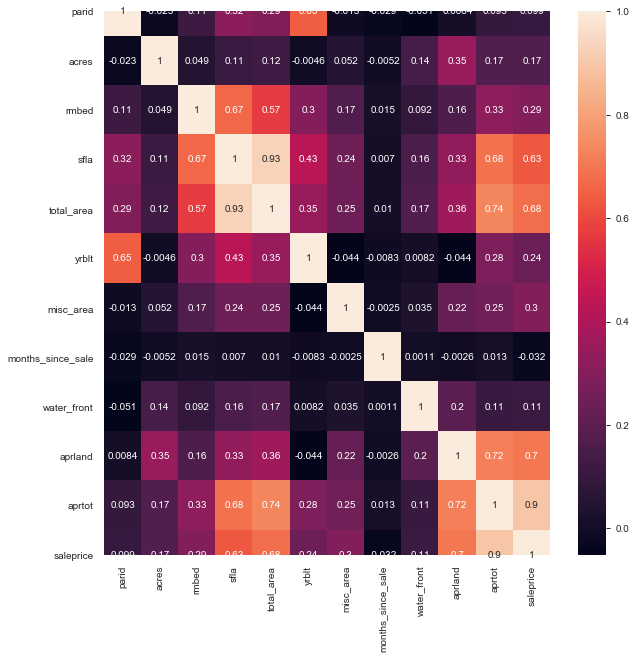

In [28]:
import seaborn as sns
sns.heatmap(df.corr(),annot=True)
#---get a reference to the current figure and set its size---  see PML chapter 12
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()


In [29]:
# next lets load GIS Data Frame
# see announcement 10/27/2020
# curl -OL http://wx.erau.edu/faculty/lehrs/ma305/volusia_gis_data.zip
gis_location = "c:\\temp\\ma305\\volusia\\volusia_gis_data.txt"
gis_df =  pd.read_csv(gis_location,sep='\t',header=(0))
gis_df.tail()


,parid,gis_x,gis_y,lon,lat
265005,8008518,569037.334340,1.658286e+06,-81.272292,28.895208
265006,8008519,640888.499385,1.769153e+06,-81.047887,29.200377
265007,8008520,640788.646827,1.769105e+06,-81.048200,29.200244
265008,8008522,615633.382382,1.815552e+06,-81.127204,29.327926
265009,8008523,615203.251426,1.815147e+06,-81.128552,29.326811


In [39]:
# join the data frame
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
df_left = pd.merge(df, gis_df, how='left', left_on='parid', right_on='parid')

# this is the spatial bounding box of volusia county in FL State Plane East Feet CRS
(llx, lly, urx, ury) = 438000,1554000,743000,1853000
xbins = np.linspace(llx, urx, 10)
ybins = np.linspace(ury, lly, 10)
print('xbins  ybins')
print(np.c_[np.round(xbins,1),np.round(ybins,1)])


xbins  ybins
[[ 438000.  1853000. ]
 [ 471888.9 1819777.8]
 [ 505777.8 1786555.6]
 [ 539666.7 1753333.3]
 [ 573555.6 1720111.1]
 [ 607444.4 1686888.9]
 [ 641333.3 1653666.7]
 [ 675222.2 1620444.4]
 [ 709111.1 1587222.2]
 [ 743000.  1554000. ]]


In [45]:
# digitize will return value of 0 when values is less than first element
# digitize will return value of len(bins) if its larger then last bin
# digitize returns the integer bin number between elements, i.e. 
#     digitize returns 1 if value > first element & value is < second element... and so on...
# this is nice as it returns a 1 based row and column number where value resides
cols = np.digitize(df_left['gis_x'], xbins)
rows = np.digitize(df_left['gis_y'], ybins)
# so for each element in the dataframe, determine which row and column of the grid the parcel is in
#np.digitize(440000, xbins)
# append these to the df_left
df_left['ROW']=rows
df_left['COL']=cols

print('Average sale price in cell:  $%.0f' % df_left[(df_left['ROW'] == 7) & (df_left['COL'] == 5)].saleprice.mean())


Average sale price in a cell:  $188236


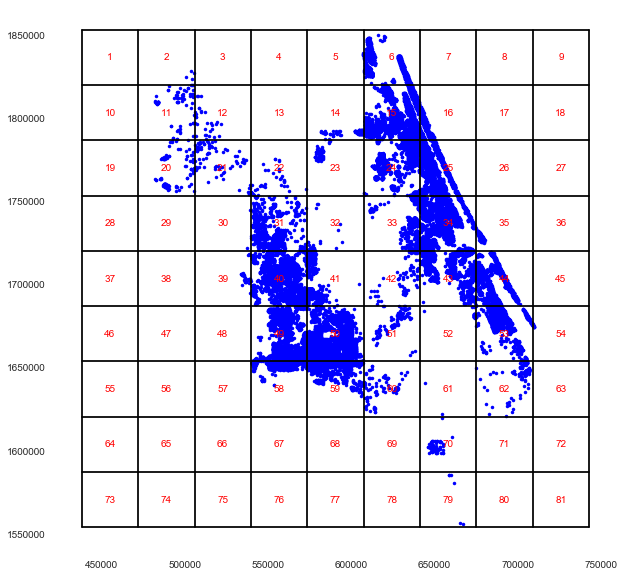

In [50]:
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.plot(df_left['gis_x'], df_left['gis_y'], 'b.')
# plot cell grid lines
for x in (xbins):
    # plot vertical lines hold x constant, draw line from the bottom to the top of the bounding box (bb)
    plt.plot([x,x], [lly,ury], 'k')
for y in (ybins):
    # plot horizontal lines, hold y constant, draw hz lines from the left to the right of the bb
    plt.plot([llx,urx], [y,y], 'k')

# create a list of lookups for ROW,COL,INDEX (using a list is recommended for performance)
lookups = [[0,0,0]]
index = 1
for y in range(len(ybins)-1):  # note row 1 is on top of grid, note how we ordered bins above
    for x in range(len(xbins)-1):
        # debuggings..  print out index row column
        # print('%d  (%d, %d)' % (index, y+1, x+1))
        # print('%d, %d, %d' % (y+1, x+1, index))
        lookups.append([y+1, x+1, index])
        # cant do this have to do the above... and 
        # df_left[(df_left['ROW']==x+1) & (df_left['COL']==y+1)].CELL=index
        text = plt.text((xbins[x]+xbins[x+1])/2, (ybins[y]+ybins[y+1])/2, index,
                       ha="center", va="center", color="r")
        index = index + 1
        
plt.axis('Equal')
plt.show()


In [47]:
# convert the lookups list to data frame
df_lookups = pd.DataFrame(lookups, columns=['ROW','COL','CELL'])
# perform a multi column merge, adding the CELL field to the df_left dataframe to match the grid
df_left = pd.merge(df_left, df_lookups, how='left', left_on=['ROW', 'COL'], right_on=['ROW', 'COL'])



In [51]:
# above we printed value for row 7 column 5, now we can make it easier on the user... for a grid index #
df_left[df_left['CELL']==59]['saleprice'].mean()
#df_left[df_left['ROW']==1]['gis_y'].mean()


188235.9657348963

In [ ]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df_left)